In [1]:
import snap
import numpy as np
import pandas as pd
from itertools import permutations
from matplotlib import pyplot as plt
import random
import glob


## This looks at one batch of data and describes the networks per batch

CAM_YEAR = 2000

In [2]:
## load contribution to candidates
filePath = "../data/financials/contributions_to_candidates/"
allFiles = filePath + str(CAM_YEAR) + ".txt"

print allFiles

result = pd.read_table(allFiles, sep='|', index_col=False, low_memory=False, 
                 names=[
                 'CMTE_ID'
                 ,'AMNDT_IND'
                 ,'RPT_TP'
                 ,'TRANSACTION_PGI'
                 ,'IMAGE_NUM'
                 ,'TRANSACTION_TP'
                 ,'ENTITY_TP'
                 ,'NAME'
                 ,'CITY'
                 ,'STATE'
                 ,'ZIP_CODE'
                 ,'EMPLOYER'
                 ,'OCCUPATION'
                 ,'TRANSACTION_DT'
                 ,'TRANSACTION_AMT'
                 ,'OTHER_ID'
                 ,'CAND_ID'
                 ,'TRAN_ID'
                 ,'FILE_NUM'
                 ,'MEMO_CD'
                 ,'MEMO_TEXT'
                 ,'SUB_ID'
                 ])


../data/financials/contributions_to_candidates/2000.txt


In [3]:
## process one batch of contribution data

result = result[['CMTE_ID','TRANSACTION_DT', 'TRANSACTION_AMT', 'CAND_ID']]
#result = result[['CMTE_ID','CAND_ID']]
result = result.groupby(['CMTE_ID','TRANSACTION_DT', 'TRANSACTION_AMT', 'CAND_ID']).size().reset_index(name='Freq')
## remove the case where committees received money from candidates
result = result[result.TRANSACTION_AMT >= 0]

result['ContributionYear'] = (result['TRANSACTION_DT'] % 10000).apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.int64)
##remove the case where years are invalid
result = result[result.ContributionYear > 0]


result["ComNodeId"] = result.groupby(['CMTE_ID']).ngroup()

print result.head()

     CMTE_ID  TRANSACTION_DT  TRANSACTION_AMT    CAND_ID  Freq  \
0  C00000042       2081999.0             1000  S4MO00037     1   
1  C00000042       2152000.0             1000  H0IL10120     1   
2  C00000042       2172000.0              500  H0IL15061     1   
3  C00000042       3132000.0              500  H2IL01042     1   
4  C00000042       3282000.0             1000  H8CT05104     1   

   ContributionYear  ComNodeId  
0              1999          0  
1              2000          0  
2              2000          0  
3              2000          0  
4              2000          0  


In [4]:
## load candidate master to map to nodeIDs
filePath = "../processed-data/candidate_node_mapping_manual.csv"

mapping = pd.read_csv(filePath, index_col=False)

print mapping.head(10)

     CAND_ID                   CAND_NAME state      lname   fname  \
0  H4LA05221          ABRAHAM, RALPH LEE    LA    ABRAHAM   RALPH   
1  H4LA05221  ABRAHAM, RALPH LEE DR. JR.    LA    ABRAHAM   RALPH   
2  H4NC12100         ADAMS, ALMA SHEALEY    NC      ADAMS    ALMA   
3  H6AL04098            ADERHOLT, ROBERT    AL   ADERHOLT  ROBERT   
4  H6AL04098          ADERHOLT, ROBERT B    AL   ADERHOLT  ROBERT   
5  H6AL04098         ADERHOLT, ROBERT B.    AL   ADERHOLT  ROBERT   
6  H6AL04098    ADERHOLT, ROBERT B. REP.    AL   ADERHOLT  ROBERT   
7  H6AL04098      ADERHOLT, ROBERT BROWN    AL   ADERHOLT  ROBERT   
8  H2CA31125               AGUILAR, PETE    CA    AGUILAR    PETE   
9  S2TN00058            ALEXANDER, LAMAR    TN  ALEXANDER   LAMAR   

      minitial bioguide_id  thomas_id  NodeID  
0          LEE     A000374        0.0     0.0  
1  LEE DR. JR.     A000374        0.0     0.0  
2      SHEALEY     A000370     2201.0     1.0  
3          NaN     A000055     1460.0     2.0  


In [5]:
# merge dataframes together
c = pd.merge(result, mapping, on='CAND_ID', how='left')

c = c.fillna('')
c[['NodeID','ComNodeId']] = c[['NodeID','ComNodeId']].apply(pd.to_numeric, errors='coerce').fillna(-1).astype(np.int64)
    
## remove entries where Nid = 0, meaning unsuccessful candidates
c = c[c.fname != '']
c = c[c.NodeID != -1]

In [6]:
print c.head(5)

     CMTE_ID  TRANSACTION_DT  TRANSACTION_AMT    CAND_ID  Freq  \
0  C00000042       2081999.0             1000  S4MO00037     1   
1  C00000042       2081999.0             1000  S4MO00037     1   
2  C00000042       2152000.0             1000  H0IL10120     1   
4  C00000042       3132000.0              500  H2IL01042     1   
5  C00000042       3132000.0              500  H2IL01042     1   

   ContributionYear  ComNodeId             CAND_NAME state     lname  fname  \
0              1999          0      ASHCROFT, JOHN D    MO  ASHCROFT   JOHN   
1              1999          0  ASHCROFT, JOHN DAVID    MO  ASHCROFT   JOHN   
2              2000          0     KIRK, MARK STEVEN    IL      KIRK   MARK   
4              2000          0         RUSH, BOBBY L    IL      RUSH  BOBBY   
5              2000          0       RUSH, BOBBY LEE    IL      RUSH  BOBBY   

  minitial bioguide_id thomas_id  NodeID  
0        D           0      1274     584  
1    DAVID           0      1274     584  

In [7]:
offset = 0

filePathNode = "../processed-data/"
f = filePathNode + "bill_node.csv"

bill = pd.read_csv(f, delimiter= ",", index_col=False)

offset = bill['NId'].apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.int64).max()

print "Committee NodeID Offset is %d" % (offset + 1)

Committee NodeID Offset is 231726


In [8]:
c['ComNodeId'] = c['ComNodeId'] + offset + 1
print(c.head(5))

     CMTE_ID  TRANSACTION_DT  TRANSACTION_AMT    CAND_ID  Freq  \
0  C00000042       2081999.0             1000  S4MO00037     1   
1  C00000042       2081999.0             1000  S4MO00037     1   
2  C00000042       2152000.0             1000  H0IL10120     1   
4  C00000042       3132000.0              500  H2IL01042     1   
5  C00000042       3132000.0              500  H2IL01042     1   

   ContributionYear  ComNodeId             CAND_NAME state     lname  fname  \
0              1999     231726      ASHCROFT, JOHN D    MO  ASHCROFT   JOHN   
1              1999     231726  ASHCROFT, JOHN DAVID    MO  ASHCROFT   JOHN   
2              2000     231726     KIRK, MARK STEVEN    IL      KIRK   MARK   
4              2000     231726         RUSH, BOBBY L    IL      RUSH  BOBBY   
5              2000     231726       RUSH, BOBBY LEE    IL      RUSH  BOBBY   

  minitial bioguide_id thomas_id  NodeID  
0        D           0      1274     584  
1    DAVID           0      1274     584  

We have now a contribution data for the year we picked, in CAM_YEAR

In [9]:
print c.shape

(465351, 15)


In [10]:
## create an undirect graph
G = snap.TUNGraph.New()
for index, row in c.iterrows():
    if G.IsNode(row['NodeID']) is False:
        G.AddNode(row['NodeID'])
    if G.IsNode(row['ComNodeId']) is False:
        G.AddNode(row['ComNodeId'])
    if G.IsEdge(row['NodeID'], row['ComNodeId']) is False:
        G.AddEdge(row['NodeID'], row['ComNodeId'])

print "G node count is %d" % (G.GetNodes())
print "G edge count is %d" % (G.GetEdges())

G node count is 4349
G edge count is 110221


## Describe the Networks

joining to the bill data in the immediately following year. E.g., if we are looking to 2000's campaign, contribution record, we need to look at 2002's congress membership and bill co-authorship data, to respect causality

In [13]:
filePathNode = "../processed-data/"
f = filePathNode + "legislator_bill_edge_list.csv"

bills = pd.read_csv(f, delimiter= ",", index_col=False)
print bills.head()

   SrcNId  DstNId  congress_term date_signed
0   10000    1002            100  1987-01-06
1   10001     649            101  1989-01-03
2   10001      40            101  1989-01-03
3   10001     710            101  1989-04-04
4   10001     888            101  1989-01-03


In [14]:
## we need to translate from congress term to year
term = 107 ## corresponding to 2001-2002 years

bills = bills[bills['congress_term'] == term]
print(bills.head())

      SrcNId  DstNId  congress_term date_signed
190    10007     580            107  2001-01-03
405    10026    1780            107  2001-01-03
1102   10045    1519            107  2001-06-05
1103   10045     144            107  2001-04-04
1104   10045    1148            107  2001-06-05


In [15]:
## Join bill data to campaign contribution data (essentially only include legislators found in the bill data)
overall = pd.merge(c, bills, left_on='NodeID', right_on = 'DstNId', how='inner')

print(c.shape)
print(bills.shape)
print(overall.shape)

(469894, 15)
(154308, 4)
(116866920, 19)


In [16]:
print overall.head(5)

     CMTE_ID  TRANSACTION_DT  TRANSACTION_AMT    CAND_ID  Freq  \
0  C00000042       2152000.0             1000  H0IL10120     1   
1  C00000042       2152000.0             1000  H0IL10120     1   
2  C00000042       2152000.0             1000  H0IL10120     1   
3  C00000042       2152000.0             1000  H0IL10120     1   
4  C00000042       2152000.0             1000  H0IL10120     1   

   ContributionYear  ComNodeId          CAND_NAME state lname fname minitial  \
0              2000     231726  KIRK, MARK STEVEN    IL  KIRK  MARK   STEVEN   
1              2000     231726  KIRK, MARK STEVEN    IL  KIRK  MARK   STEVEN   
2              2000     231726  KIRK, MARK STEVEN    IL  KIRK  MARK   STEVEN   
3              2000     231726  KIRK, MARK STEVEN    IL  KIRK  MARK   STEVEN   
4              2000     231726  KIRK, MARK STEVEN    IL  KIRK  MARK   STEVEN   

  bioguide_id thomas_id  NodeID  SrcNId  DstNId  congress_term date_signed  
0     K000360      1647     271   10121     2

### Plot Degree Distribution

In [17]:
bill_cand = []
for index, row in bills.iterrows():
    bill_cand.append(row['DstNId'])
bill_cand = list(set(bill_cand)) ##dedup

G_cand = snap.TUNGraph.New()
for index, row in c.iterrows():
    if G_cand.IsNode(row['NodeID']) is False and row['NodeID'] in bill_cand:
        G_cand.AddNode(row['NodeID'])
    if G_cand.IsNode(row['ComNodeId']) is False and row['NodeID'] in bill_cand:
        G_cand.AddNode(row['ComNodeId'])
    if G_cand.IsEdge(row['NodeID'], row['ComNodeId']) is False and row['NodeID'] in bill_cand:
        G_cand.AddEdge(row['NodeID'], row['ComNodeId'])

print "G_cand node count is %d" % (G_cand.GetNodes())
print "G_cand edge count is %d" % (G_cand.GetEdges())

G_cand node count is 4087
G_cand edge count is 97122


In [18]:
# Find clique size

cand = []
com = []
#b = []
for NI in G_cand.Nodes():
    if NI.GetId() < 10000:
        cand.append(NI.GetOutDeg())
    else:
        com.append(NI.GetOutDeg())
        
print "Campaign network max clique size is %d for candidates, out of %d pool" % (max(cand), len(cand))
print "Campaign network max clique size is %d for committees, out of %d pool" % (max(com), len(com))
#print "Campaign network max clique size is %d for bills, out of %d pool" % (max(b), len(b)) ## this is with joining to the bill data

Campaign network max clique size is 673 for candidates, out of 523 pool
Campaign network max clique size is 443 for committees, out of 3564 pool


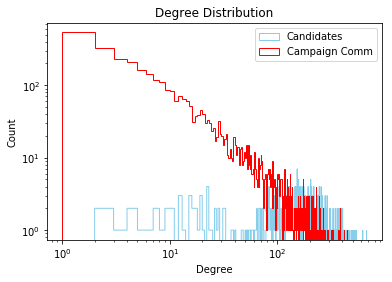

In [21]:
plt.hist(cand, bins=range(min(cand), max(cand)+1), color = "skyblue", ec="skyblue", histtype = 'step', label="Candidates")
plt.hist(com, bins=range(min(com), max(com)+1), color="red", ec="red", histtype = 'step', label= 'Campaign Comm')
plt.xscale("log")
plt.yscale("log")
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Degree Distribution')
plt.legend()
plt.show()

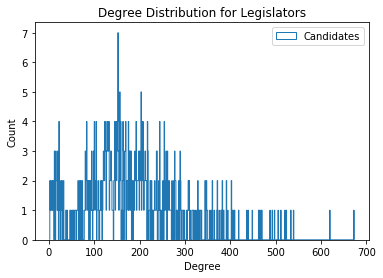

In [22]:
plt.figure()
plt.hist(cand, bins=range(min(cand), max(cand)+1),histtype = 'step', label="Candidates")
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('Degree Distribution for Legislators')
plt.legend()
plt.show()

In [23]:
## Fold G_cand to create a one-node projection onto candidate nodes

H = snap.TUNGraph.New()

for i in G_cand.Nodes():
    for j in G_cand.Nodes():
        if (i.GetId() < j.GetId() and j.GetId() < 10000): #10000 is the upper limit for candidate nodes
            NbrV = snap.TIntV()
            Num = snap.GetLen2Paths(G_cand, i.GetId(), j.GetId(), NbrV)
            if Num > 0:
                if H.IsNode(i.GetId()) == False:
                    H.AddNode(i.GetId())
                if H.IsNode(j.GetId()) == False:
                    H.AddNode(j.GetId())
                if H.IsEdge(i.GetId(), j.GetId()) == False:
                    H.AddEdge(i.GetId(),j.GetId())

print "Compressed Graph Node count total: %d" % (H.GetNodes())

print "Compressed Edge count total: %d" % (H.GetEdges())

GraphClustCoeff = snap.GetClustCf(H, -1)
print "Campaign Network Clustering coefficient: %f" % GraphClustCoeff

Compressed Graph Node count total: 523
Compressed Edge count total: 132662
Campaign Network Clustering coefficient: 0.984719


In [24]:
MxWcc = snap.GetMxWcc(H)
print MxWcc.GetNodes()
print MxWcc.GetEdges()

523
132662


In [26]:
MxScc = snap.GetMxScc(H)
print "Campaign Network Max Strongly Connected Component Node Count: %d" % MxScc.GetNodes()
print "Campaign Network Max Strongly Connected Component Edge Count: %d" % MxScc.GetEdges()


Campaign Network Max Strongly Connected Component Node Count: 523
Campaign Network Max Strongly Connected Component Edge Count: 132662


In [27]:
print bills.head()

      SrcNId  DstNId  congress_term date_signed
190    10007     580            107  2001-01-03
405    10026    1780            107  2001-01-03
1102   10045    1519            107  2001-06-05
1103   10045     144            107  2001-04-04
1104   10045    1148            107  2001-06-05


In [28]:
print "...Looking at Bill - Legislator Graph first"
## NOW, create one-node projection onto legislator graphs

G_bill = snap.TUNGraph.New()
for index, row in bills.iterrows():
    if G_bill.IsNode(row['SrcNId']) is False:
        G_bill.AddNode(row['SrcNId'])
    if G_bill.IsNode(row['DstNId']) is False:
        G_bill.AddNode(row['DstNId'])
    if G_bill.IsEdge(row['SrcNId'], row['DstNId']) is False:
        G_bill.AddEdge(row['SrcNId'], row['DstNId'])

print "G_bill node count is %d" % (G_bill.GetNodes())
print "G_bill edge count is %d" % (G_bill.GetEdges())

## Find clique size
cand = []
com = []
#b = []
for NI in G_bill.Nodes():
    if NI.GetId() < 10000:
        cand.append(NI.GetOutDeg())
    else:
        com.append(NI.GetOutDeg())
        
print "Bill network max node degree is %d for legislators, out of %d pool" % (max(cand), len(cand))
print "Bill network max node degree is %d for bills, out of %d pool" % (max(com), len(com))

## Fold G_cand to create a one-node projection onto candidate nodes

H_bill = snap.TUNGraph.New()

for i in G_bill.Nodes():
    for j in G_bill.Nodes():
        if (i.GetId() < j.GetId() and j.GetId() < 10000): #10000 is the upper limit for candidate nodes
            NbrV = snap.TIntV()
            Num = snap.GetCmnNbrs(G_bill,i.GetId(),j.GetId())
            #Num = snap.GetLen2Paths(G_bill, i.GetId(), j.GetId(), NbrV)
            if Num != 0:
                if H_bill.IsNode(i.GetId()) == False:
                    H_bill.AddNode(i.GetId())
                if H_bill.IsNode(j.GetId()) == False:
                    H_bill.AddNode(j.GetId())
                if H_bill.IsEdge(i.GetId(), j.GetId()) == False:
                    H_bill.AddEdge(i.GetId(),j.GetId())

print "One-node Projected Graph Node count total: %d" % (H_bill.GetNodes())

print "One-node Projected Edge count total: %d" % (H_bill.GetEdges())

GraphClustCoeff = snap.GetClustCf(H_bill, -1)
print "Bill Network Clustering coefficient: %f" % GraphClustCoeff

MxWcc = snap.GetMxWcc(H_bill)
print "Bill Network Max Weakly Connected Component Node Count: %d" % MxWcc.GetNodes()
print "Bill Network Max Weakly Connected Component Edge Count: %d" % MxWcc.GetEdges()

MxScc = snap.GetMxScc(H_bill)
print "Bill Network Max Strongly Connected Component Node Count: %d" % MxScc.GetNodes()
print "Bill Network Max Strongly Connected Component Edge Count: %d" % MxScc.GetEdges()


...Looking at Bill - Legislator Graph first
G_bill node count is 11338
G_bill edge count is 154308
Bill network max node degree is 987 for legislators, out of 549 pool
Bill network max node degree is 404 for bills, out of 10789 pool
One-node Projected Graph Node count total: 549
One-node Projected Edge count total: 104903
Bill Network Clustering coefficient: 0.998657
Bill Network Max Weakly Connected Component Node Count: 448
Bill Network Max Weakly Connected Component Edge Count: 99854
Bill Network Max Strongly Connected Component Node Count: 448
Bill Network Max Strongly Connected Component Edge Count: 99854
